# Fit AdapIF to HH Spike Trains

In [1]:
from brian2 import *
from brian2modelfitting import *

import numpy as np

INFO       Cache size for target "cython": 1102 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/alteska/.cython/brian_extensions" directory. [brian2]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyte

In [2]:
dt = 0.01*ms
defaultclock.dt = dt

## Load the Data

In [17]:
voltage1 = genfromtxt('voltage1nA.csv', delimiter=',')
voltage2 = genfromtxt('voltage2nA.csv', delimiter=',')

In [3]:
inp_cur1 = genfromtxt('inp_cur1nA.csv', delimiter=',')
inp_cur2 = genfromtxt('inp_cur2nA.csv', delimiter=',')
inp_current = [inp_cur1, inp_cur2]
inp_current

[array([0.        , 0.05553714, 0.18616409, ..., 0.34263957, 0.23894004,
        0.24489567]),
 array([ 0.        , -0.08325095,  0.03536872, ...,  0.76675788,
         0.90452414,  1.0627096 ])]

In [4]:
out_spikes1 = genfromtxt('out_spikes1nA.csv', delimiter=',')
out_spikes2 = genfromtxt('out_spikes2nA.csv', delimiter=',')
out_spikes = [out_spikes1, out_spikes2]
out_spikes

[array([  71.23,  122.83,  210.92,  225.54,  239.2 ,  281.24,  303.7 ,
         336.2 ,  399.15,  536.37,  597.07,  663.54,  811.95,  939.29,
         962.57,  991.39, 1009.98, 1035.9 , 1078.18, 1113.35, 1155.7 ,
        1200.08, 1270.3 , 1293.  , 1315.59, 1467.74, 1488.74, 1522.48,
        1554.55, 1571.92, 1670.46, 1705.1 , 1730.37, 1746.35, 1793.  ,
        1866.76, 1892.38, 1937.42, 1948.02, 1986.21, 2111.73, 2171.24,
        2276.79, 2418.89, 2440.3 , 2546.8 , 2584.71, 2599.82, 2662.19,
        2837.62, 2961.99, 3005.25, 3059.41, 3177.22, 3190.72, 3252.33,
        3349.37, 3418.14, 3466.01, 3521.96, 3604.86, 3638.6 , 3660.36,
        3680.88, 3691.25, 3720.41, 3829.22, 3867.82, 3904.32, 3951.12,
        3961.46, 4031.54, 4085.24, 4118.16, 4163.5 , 4199.79, 4264.13,
        4357.91, 4377.63, 4440.7 , 4477.18, 4573.26, 4614.94, 4676.63,
        4696.7 , 4713.32, 4843.36]),
 array([4.81000e+00, 2.39700e+01, 6.56500e+01, 7.03400e+01, 1.01920e+02,
        1.10710e+02, 1.17300e+02, 2.47

## Model Fitting

In [5]:
eqs = Equations(
"""
dv/dt = (gL*(EL - v) + gL*DeltaT*exp((v - VT)/DeltaT) + I*k - w)/C : volt
dw/dt = (a*(v - EL) - w)/tauw : amp
Vcut = VT + 50 * DeltaT : volt
taum = C / gL : second
gL: siemens (constant)
a : siemens (constant)
b : amp (constant)
VT : volt (constant)
DeltaT : volt (constant)
Vr : volt (constant)
k : 1 (constant)
C : farad (constant)
tauw : second (constant)
""", 
# EL : volt (constant)
# C: farad (constant)
# gL = 60 * nS,
# VT = -50.4 * mV,
# DeltaT = 5 * mV,    
# a = 4*nS,
# b = 0.0805*nA,
# Vr = -70.6*mV
# C = 171 * pF,
# tauw = 144*ms,
EL = -65 * mV,
)

In [6]:
n_opt = NevergradOptimizer()
metric = GammaFactor(time=1*second, delta=10*ms)

In [7]:
# pass parameters to the NeuronGroup
fitter = SpikeFitter(model=eqs, input_var='I', dt=dt,
                     input=inp_current * nA, output=out_spikes,
                     n_samples=20,
                     threshold='v>Vcut',
                     reset="v=Vr; w+=b",
                     refractory=1.41*ms,
                     param_init={'v': -65*mV},
                     )

In [8]:
result_dict, error = fitter.fit(n_rounds=4,
                                optimizer=n_opt,
                                metric=metric,
                                callback='text',
                                gL=[30*nS, 60*nS],
                                a = [0, 20]*nS,
                                b = [0, 0.1]*nA,
                                VT = [-90, -10] * mV,
                                DeltaT = [5, 8] * mV,    
                                Vr = [-90, -30]*mV,
                                k = [0.01, 2],
                                C = [170, 200] * pF,
                                tauw = [0.1, 500]*ms,
                               )

WARNING    neurons's variable 'w' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurons's variable 'v' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]


Round 0: fit (1.8772637269254315e-10, 1.5338753687472418e-08, 3.9834792389838054e-11, -0.06690764118966136, 0.007480570784230029, 0.5162597495154753, 0.19462998219701555, -0.06732492369456566, 4.1895652553150765e-08) with error: 0.1343087131279722
Round 1: fit (1.8772637269254315e-10, 1.5338753687472418e-08, 3.9834792389838054e-11, -0.06690764118966136, 0.007480570784230029, 0.5162597495154753, 0.19462998219701555, -0.06732492369456566, 4.1895652553150765e-08) with error: 0.1343087131279722
Round 2: fit (1.7469166932680202e-10, 1.6215591951372388e-08, 8.064689328857298e-11, -0.08028605863001875, 0.00780368697410303, 0.313032750261658, 0.28359096915774695, -0.07922572620804563, 5.19121355441096e-08) with error: 0.045174404920691136
Round 3: fit (1.7469166932680202e-10, 1.6215591951372388e-08, 8.064689328857298e-11, -0.08028605863001875, 0.00780368697410303, 0.313032750261658, 0.28359096915774695, -0.07922572620804563, 5.19121355441096e-08) with error: 0.045174404920691136


In [9]:
result_dict

{'C': 1.7469166932680202e-10,
 'a': 1.6215591951372388e-08,
 'b': 8.064689328857298e-11,
 'VT': -0.08028605863001875,
 'DeltaT': 0.00780368697410303,
 'k': 0.313032750261658,
 'tauw': 0.28359096915774695,
 'Vr': -0.07922572620804563,
 'gL': 5.19121355441096e-08}

In [10]:
error

0.045174404920691136

In [11]:
1 - error

0.9548255950793089

In [12]:
# visualization of the results
spikes = fitter.generate_spikes(params=None)
print('spike times:', spikes)

spike times: [array([5.20000e-01, 3.05000e+00, 5.10000e+00, 8.18000e+00, 1.17500e+01,
       1.49800e+01, 1.82800e+01, 2.13200e+01, 2.41000e+01, 2.81100e+01,
       3.32800e+01, 3.79300e+01, 4.42000e+01, 4.82500e+01, 5.65800e+01,
       6.11800e+01, 7.04900e+01, 8.08600e+01, 1.01120e+02, 1.19600e+02,
       1.24060e+02, 1.61120e+02, 1.72760e+02, 1.80750e+02, 2.09330e+02,
       2.19980e+02, 2.27970e+02, 2.34590e+02, 2.44380e+02, 2.79900e+02,
       2.89940e+02, 3.04910e+02, 3.27030e+02, 3.39960e+02, 3.77310e+02,
       3.83270e+02, 4.00070e+02, 4.06290e+02, 4.48060e+02, 4.59840e+02,
       4.68640e+02, 4.98270e+02, 5.05990e+02, 5.27070e+02, 5.36530e+02,
       5.73590e+02, 5.86550e+02, 5.92040e+02, 5.99960e+02, 6.40130e+02,
       6.53220e+02, 6.60430e+02, 6.65470e+02, 6.79210e+02, 7.22540e+02,
       7.55840e+02, 7.63580e+02, 7.76440e+02, 7.86180e+02, 8.02940e+02,
       8.09890e+02, 8.39670e+02, 8.50640e+02, 8.70560e+02, 8.84690e+02,
       9.27290e+02, 9.33870e+02, 9.38140e+02, 9.44

In [13]:
print(len(out_spikes[0]))
print(len(spikes[0]))

87
308


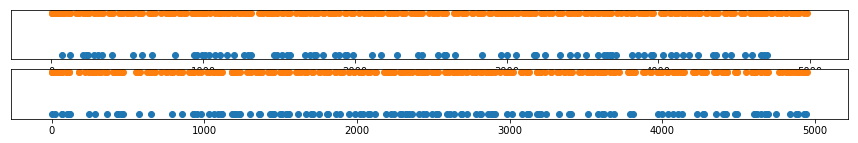

In [14]:
d=-1

fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

ax[1].set_yticks(np.arange(0, 1, step=1))
ax[1].scatter(out_spikes[1][:d], np.ones_like(out_spikes[1][:d]));
ax[1].scatter(spikes[1][:d], np.ones_like(spikes[1][:d])*2);

In [15]:
fits = fitter.generate(params=None, output_var='v',)

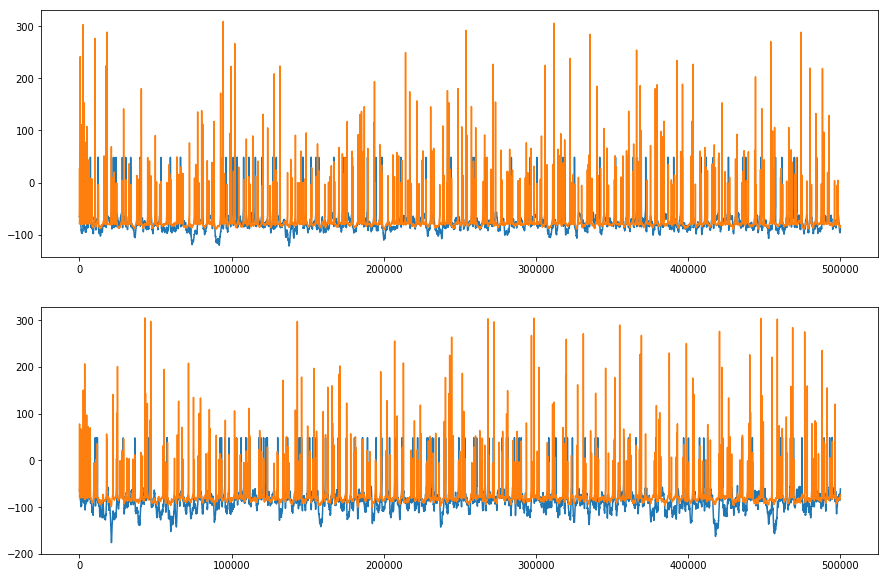

In [18]:
fig, ax = plt.subplots(nrows=2, figsize=(15,10))

ax[0].plot(voltage1);
ax[0].plot(fits[0]/mV)

ax[1].plot(voltage2);
ax[1].plot(fits[1]/mV);
